In [33]:
# import packages

import os
import rasterio
from rasterio.mask import mask
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import geopandas as gpd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from functools import reduce

# Read in data
# Set base file path
file_path = r'C:\Users\Teddy\Documents\TZ'

# Import CSV
data_path = file_path + '/20240521TZ_Data.csv'
data = pd.read_csv(data_path)

# Read polygon files
polygon_BGT = gpd.read_file(file_path + '/Polygon/BGT_boundingBox.shp')
polygon_RWPR = gpd.read_file(file_path + '/Polygon/RWPR_boundingBox.shp')

# Polygon geometry
geometry_BGT = polygon_BGT.geometry.values[0]
geometry_RWPR = polygon_RWPR.geometry.values[0]

# Read raster files
raster_path = file_path + '/Rasters'
raster_files = os.listdir(raster_path)

print(data.head())

      ID community  visit   INDEX        date         raster  creatinine  \
0  B001F       BGT      4  B001F4  12/11/2022  _2022_331_345   49.513109   
1  B007F       BGT      4  B007F4  12/11/2022  _2022_331_345  149.887640   
2  B010M       BGT      4  B010M4  12/11/2022  _2022_331_345  121.048689   
3  B012F       BGT      4  B012F4  12/11/2022  _2022_331_345  165.617977   
4  B007F       BGT      3  B007F3   9/19/2022  _2022_248_262  122.172285   

   LOD_UTAS   UTAS_raw    LOD_UV  ...        UW       UPT       UPB       UUR  \
0     0.027   1.635677  0.003085  ...  0.305314  0.019799  0.114520  0.025931   
1     0.027  12.305650  0.003085  ...  0.023859  0.019799  0.535067  0.003947   
2     0.027   6.064023  0.003085  ...  0.033850  0.019799  0.030484  0.012489   
3     0.027  10.725708  0.003085  ...  0.080481  0.019799  0.087293  0.016079   
4     0.027   6.101070  0.003351  ...  0.023610  0.019799  0.260595  0.003753   

        UCD       UMN          SCU          SZN      STA

In [42]:
# Dictionary to store the extracted values
extracted_values_BGT = {}
extracted_values_RWPR = {}

# Dictionaries to store analyte values

#BGT
analyte_UUR = {}
analyte_UBE = {}
analyte_USE = {}
analyte_UPB = {}

#RWPR
analyte_USB = {}
analyte_UCS = {}
analyte_UCO = {}
analyte_USN = {}

# Loop through rasters to extract by mask and store raster values in lists
for raster_file in raster_files:
    raster_name = os.path.splitext(raster_file)[0]
    raster_full_path = os.path.join(raster_path, raster_file)
    
    with rasterio.open(raster_full_path) as src:
        # Extract values for BGT community
        out_image_BGT, out_transform_BGT = mask(src, [geometry_BGT], crop=True)
        values_BGT = np.array(out_image_BGT).flatten()
        values_BGT = values_BGT[values_BGT != src.nodata]  # Remove no data values
        list_name_BGT = f"BGT_{raster_name}"
        extracted_values_BGT[list_name_BGT] = values_BGT.tolist()
        analyte_UUR[list_name_BGT] = data.loc[(data['community'] == 'BGT') & (data['raster'] == raster_name), 'UUR']
        analyte_UBE[list_name_BGT] = data.loc[(data['community'] == 'BGT') & (data['raster'] == raster_name), 'UBE']
        analyte_USE[list_name_BGT] = data.loc[(data['community'] == 'BGT') & (data['raster'] == raster_name), 'USE']
        analyte_UPB[list_name_BGT] = data.loc[(data['community'] == 'BGT') & (data['raster'] == raster_name), 'UPB']
        # Extract values for RWPR community
        out_image_RWPR, out_transform_RWPR = mask(src, [geometry_RWPR], crop=True)
        values_RWPR = np.array(out_image_RWPR).flatten()
        values_RWPR = values_RWPR[values_RWPR != src.nodata]  # Remove no data values
        list_name_RWPR = f"RWPR_{raster_name}"
        extracted_values_RWPR[list_name_RWPR] = values_RWPR.tolist()
        analyte_USB[list_name_RWPR] = data.loc[(data['community'] == 'RWPR') & (data['raster'] == raster_name), 'USB']
        analyte_UCS[list_name_RWPR] = data.loc[(data['community'] == 'RWPR') & (data['raster'] == raster_name), 'UCS']
        analyte_UCO[list_name_RWPR] = data.loc[(data['community'] == 'RWPR') & (data['raster'] == raster_name), 'UCO']
        analyte_USN[list_name_RWPR] = data.loc[(data['community'] == 'RWPR') & (data['raster'] == raster_name), 'USN']

In [3]:
# Not entirely necessary - just out of curiousity 
# Check for outliers in environmental data
def outlier_proportion(values):
    if len(values) < 4:  # Not enough data to calculate IQR
        return 0
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = [value for value in values if value < lower_bound or value > upper_bound]
    return len(outliers) / len(values)

# Check each list in extracted_values for outliers and print the proportion of outliers if greater than 0%
for list_name, values in extracted_values.items():
    proportion = outlier_proportion(values)
    if proportion > 0:
        print(f"List {list_name} has {proportion:.2%} outliers")

List BGT__2019_125_139 has 1.96% outliers
List RWPR__2019_125_139 has 6.68% outliers
List BGT__2019_223_237 has 1.96% outliers
List BGT__2019_299_313 has 5.88% outliers
List RWPR__2019_299_313 has 5.65% outliers
List BGT__2019_300_314 has 5.88% outliers
List RWPR__2019_300_314 has 4.86% outliers
List RWPR__2019_322_336 has 3.13% outliers
List BGT__2020_026_040 has 7.84% outliers
List RWPR__2020_026_040 has 0.70% outliers
List RWPR__2020_041_055 has 0.42% outliers
List RWPR__2020_043_057 has 0.05% outliers
List BGT__2021_248_262 has 7.84% outliers
List RWPR__2021_248_262 has 0.19% outliers
List BGT__2021_252_266 has 7.84% outliers
List RWPR__2021_252_266 has 0.19% outliers
List RWPR__2021_269_283 has 0.61% outliers
List RWPR__2022_083_097 has 6.96% outliers
List RWPR__2022_149_163 has 0.61% outliers
List RWPR__2022_150_164 has 0.05% outliers
List BGT__2022_248_262 has 1.96% outliers
List RWPR__2022_331_345 has 0.56% outliers


In [17]:
# Plot distribution of raster and analyte values
extracted_BGT_df = pd.DataFrame({key: pd.Series(value) for key, value in extracted_values_BGT.items()})
extracted_RWPR_df = pd.DataFrame({key: pd.Series(value) for key, value in extracted_values_RWPR.items()})

UUR_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_UUR.items()})
UBE_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_UBE.items()})
USE_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_USE.items()})
UPB_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_UPB.items()})


USB_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_USB.items()})
UCS_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_UCS.items()})
UCO_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_UCO.items()})
USN_df = pd.DataFrame({key: pd.Series(value) for key, value in analyte_USN.items()})

# Wide to long
melted_BGT_df = extracted_BGT_df.melt(var_name='List', value_name='Values')
melted_RWPR_df = extracted_RWPR_df.melt(var_name='List', value_name='Values')

UUR_df_melted = UUR_df.melt(var_name='List', value_name='UUR_val')
UBE_df_melted = UBE_df.melt(var_name='List', value_name='UBE_val')
USE_df_melted = USE_df.melt(var_name='List', value_name='USE_val')
UPB_df_melted = UPB_df.melt(var_name='List', value_name='UPB_val')

USB_df_melted = USB_df.melt(var_name='List', value_name='USB_val')
UCS_df_melted = UCS_df.melt(var_name='List', value_name='UCS_val')
UCO_df_melted = UCO_df.melt(var_name='List', value_name='UCO_val')
USN_df_melted = USN_df.melt(var_name='List', value_name='USN_val')

# Alphabetize lists
melted_BGT_df = melted_BGT_df.sort_values('List')
melted_RWPR_df = melted_RWPR_df.sort_values('List')

UUR_df_melted = UUR_df_melted.sort_values('List')
UBE_df_melted = UBE_df_melted.sort_values('List')
USE_df_melted = USE_df_melted.sort_values('List')
UPB_df_melted = UPB_df_melted.sort_values('List')

USB_df_melted = USB_df_melted.sort_values('List')
UCS_df_melted = UCS_df_melted.sort_values('List')
UCO_df_melted = UCO_df_melted.sort_values('List')
USN_df_melted = USN_df_melted.sort_values('List')

# Function to convert day of the year to month and year label
def day_of_year_to_label(day, year):
    date = datetime(year, 1, 1) + timedelta(days=day - 1)
    return date.strftime("%B %Y")

# Extract year, start day, end day, and community from the list name and convert to label
def convert_list_name_to_label(list_name):
    parts = list_name.split("__")
    community = parts[0]
    year_day = parts[1].split("_")
    year = int(year_day[0])
    start_day = int(year_day[1])
    end_day = int(year_day[2])
    month_year_label = day_of_year_to_label(start_day, year)
    return f"{community}, {month_year_label} ({start_day}-{end_day})"

# Apply the conversion to get intuitive labels
melted_BGT_df['IntuitiveLabel'] = melted_BGT_df['List'].apply(convert_list_name_to_label)
melted_RWPR_df['IntuitiveLabel'] = melted_RWPR_df['List'].apply(convert_list_name_to_label)

UUR_df_melted['IntuitiveLabel'] = UUR_df_melted['List'].apply(convert_list_name_to_label)
UBE_df_melted['IntuitiveLabel'] = UBE_df_melted['List'].apply(convert_list_name_to_label)
USE_df_melted['IntuitiveLabel'] = USE_df_melted['List'].apply(convert_list_name_to_label)
UPB_df_melted['IntuitiveLabel'] = UPB_df_melted['List'].apply(convert_list_name_to_label)

USB_df_melted['IntuitiveLabel'] = USB_df_melted['List'].apply(convert_list_name_to_label)
UCS_df_melted['IntuitiveLabel'] = UCS_df_melted['List'].apply(convert_list_name_to_label)
UCO_df_melted['IntuitiveLabel'] = UCO_df_melted['List'].apply(convert_list_name_to_label)
USN_df_melted['IntuitiveLabel'] = USN_df_melted['List'].apply(convert_list_name_to_label)



C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\1211039052.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)


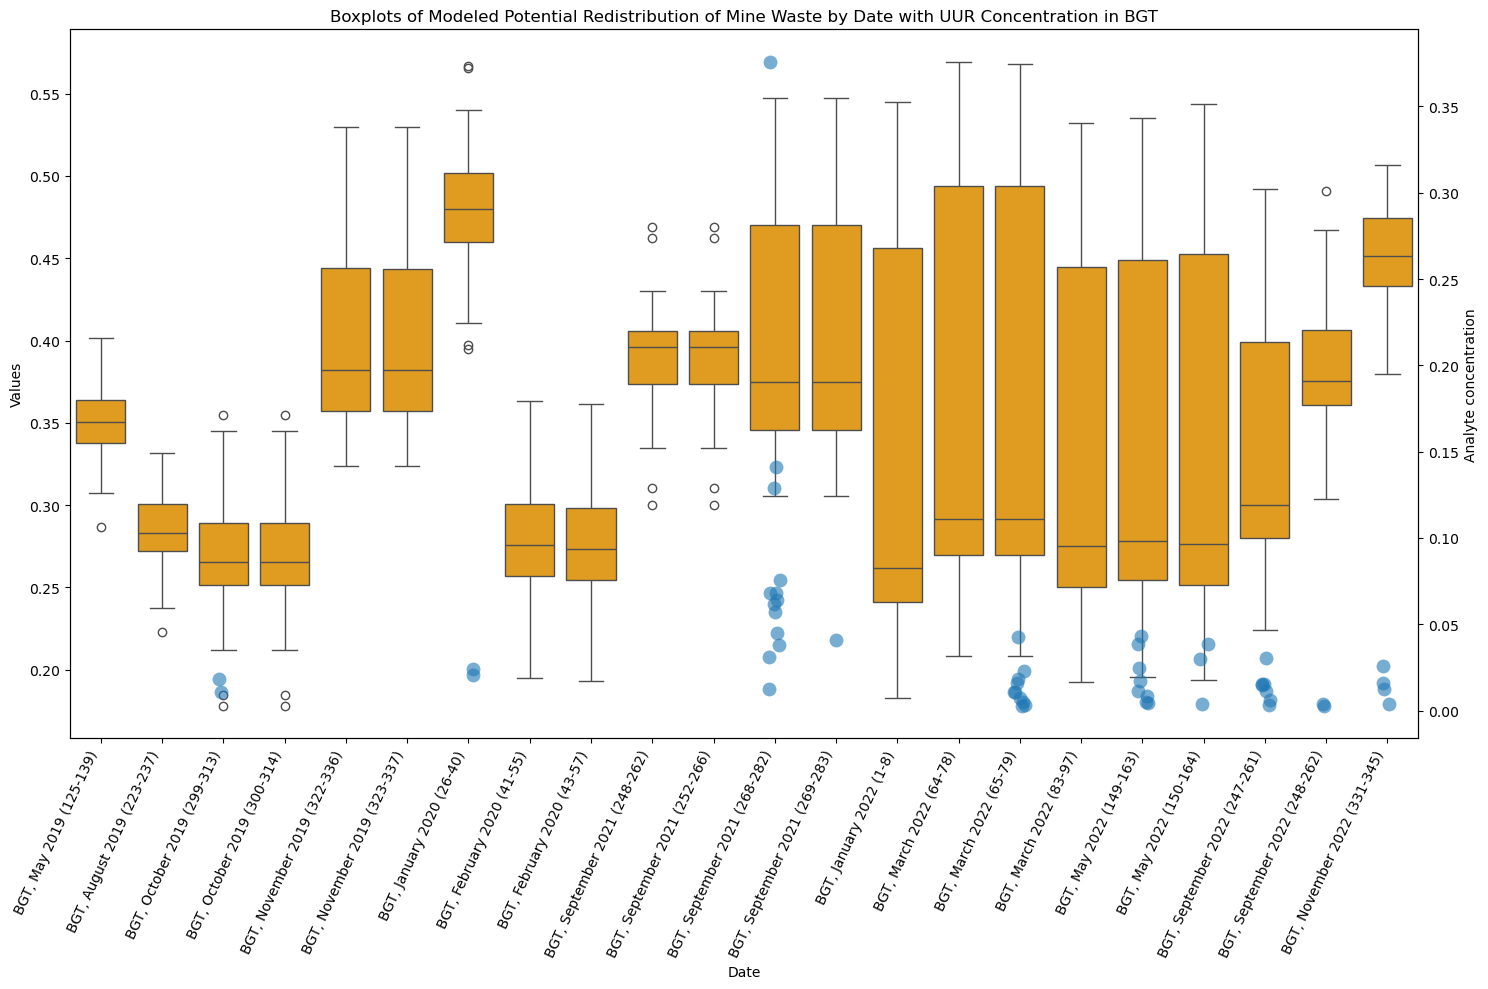

In [18]:
#Plot UUR
# Create a color palette
unique_labels = melted_BGT_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=UUR_df_melted, x='IntuitiveLabel', y='UUR_val', size=10, alpha=0.6, ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with UUR Concentration in BGT')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\2363382608.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)


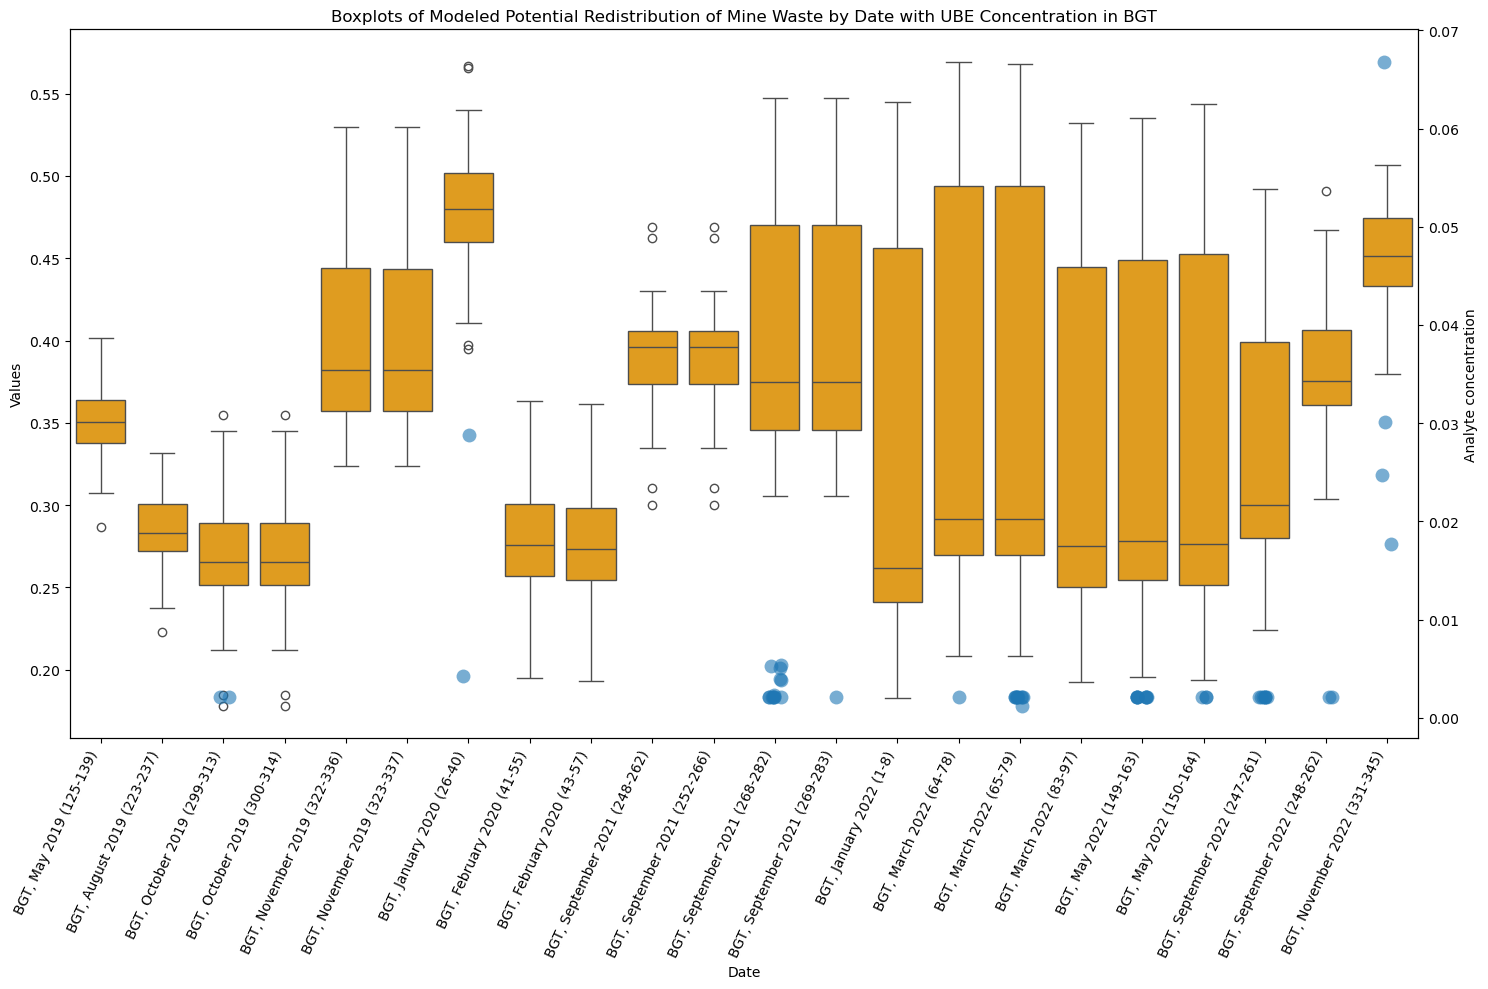

In [28]:
#Plot UBE
# Create a color palette
unique_labels = melted_BGT_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=UBE_df_melted, x='IntuitiveLabel', y='UBE_val', size=10, alpha=0.6, ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with UBE Concentration in BGT')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\3903964803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)


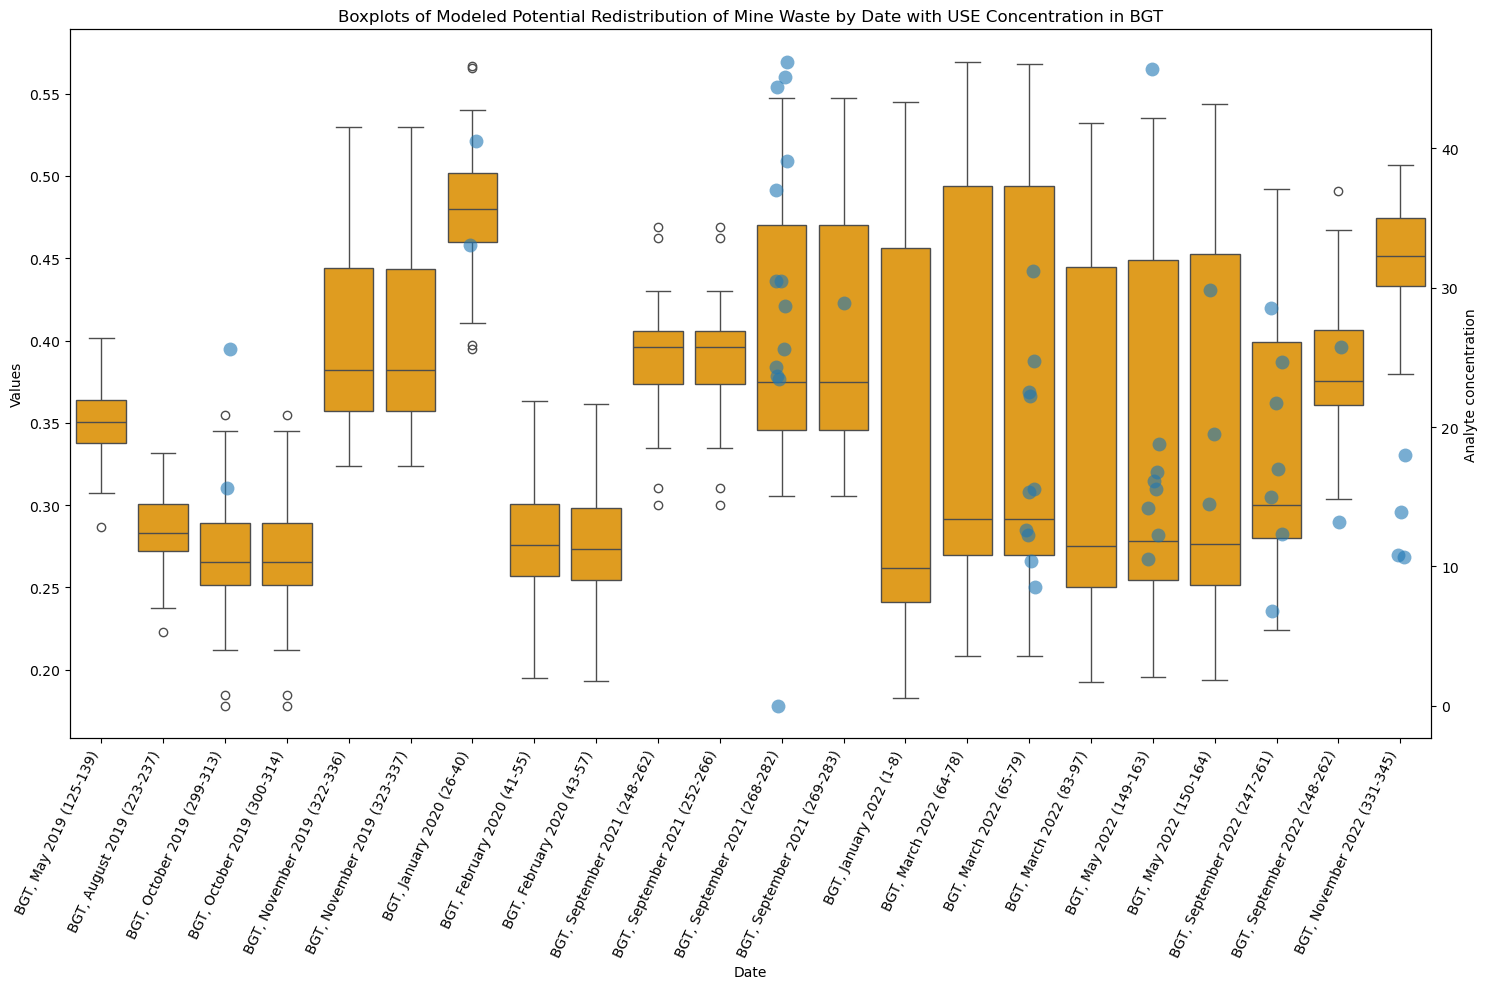

In [29]:
#Plot USE
# Create a color palette
unique_labels = melted_BGT_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=USE_df_melted, x='IntuitiveLabel', y='USE_val', size=10, alpha=0.6, ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with USE Concentration in BGT')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\1847981920.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)


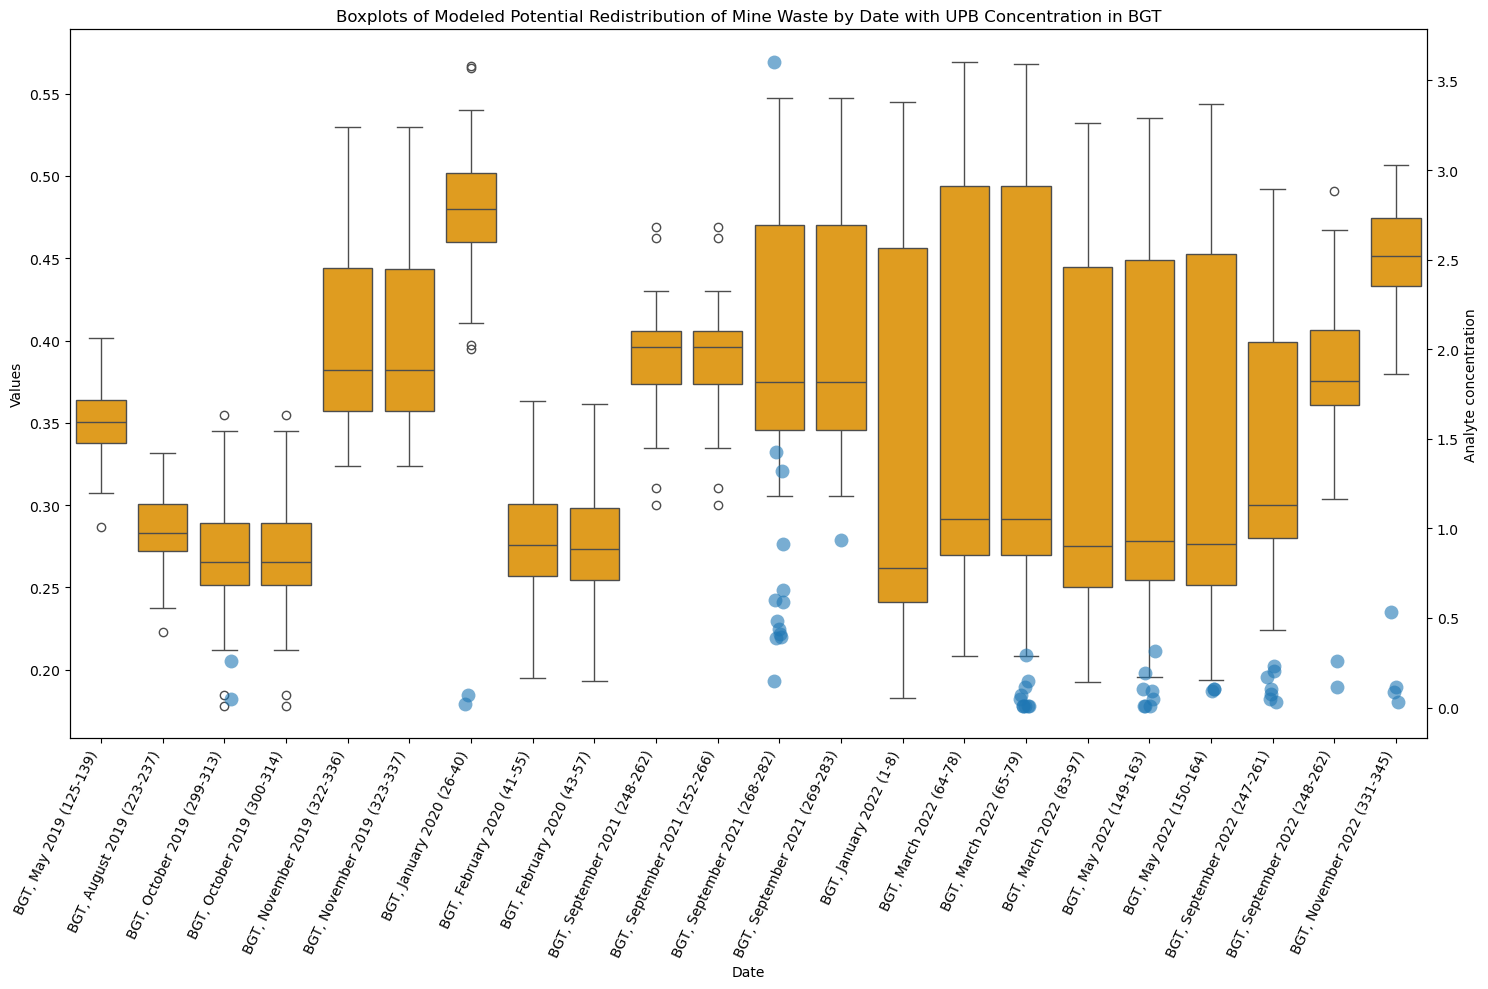

In [30]:
#Plot UPB
# Create a color palette
unique_labels = melted_BGT_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_BGT_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=UPB_df_melted, x='IntuitiveLabel', y='UPB_val', size=10, alpha=0.6, ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with UPB Concentration in BGT')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\1973705180.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)


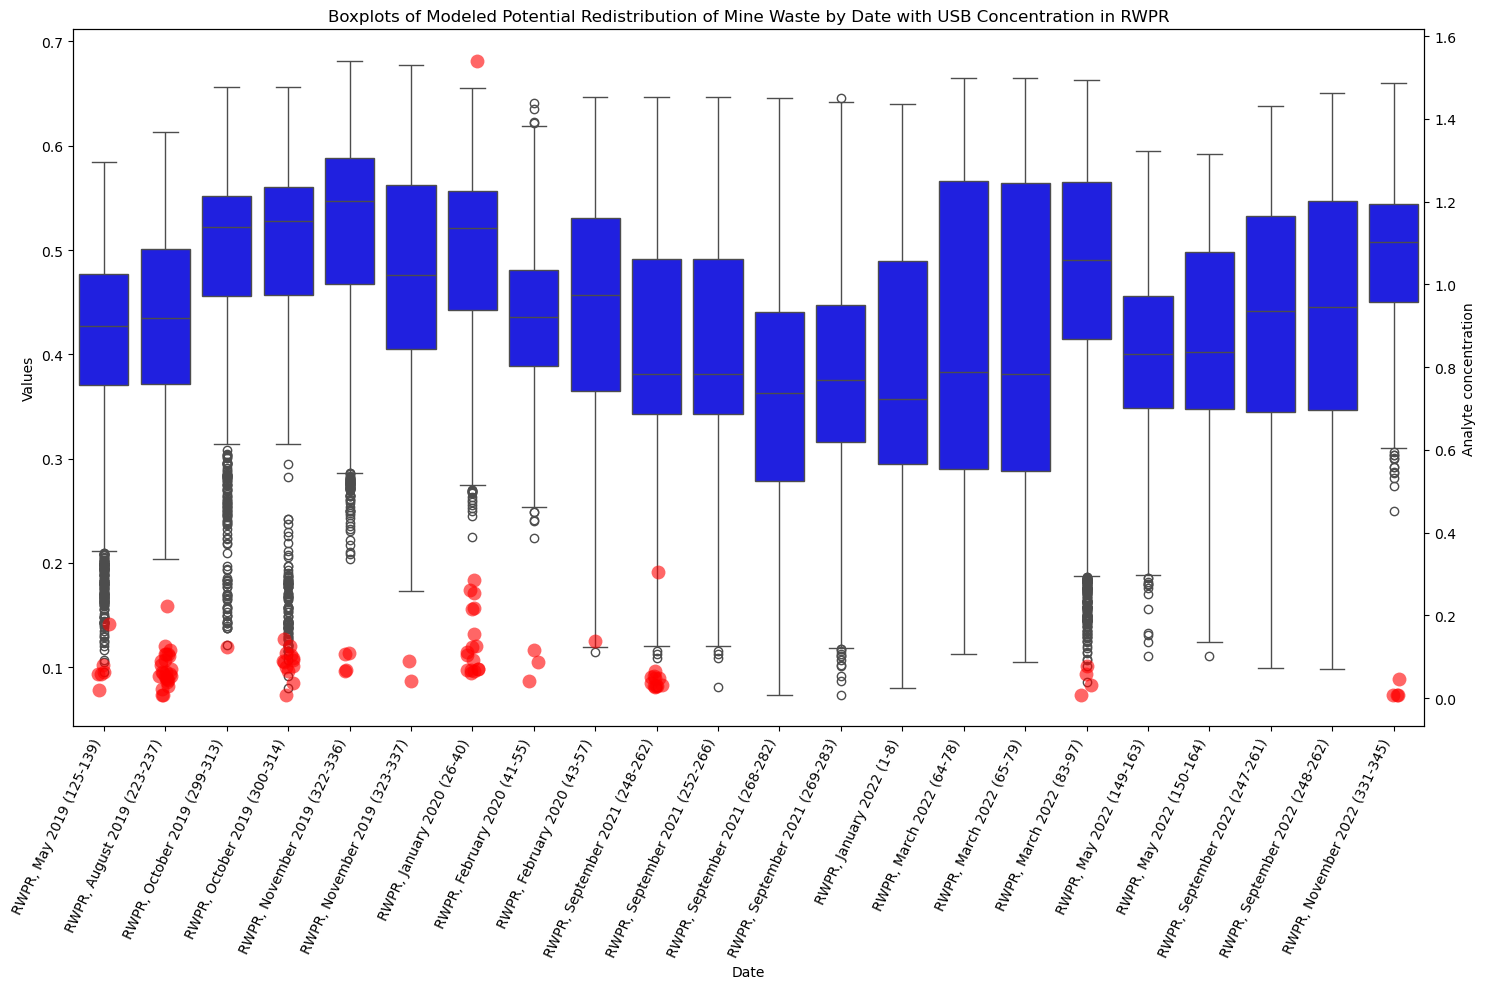

In [31]:
#Plot USB
# Create a color palette
unique_labels = melted_RWPR_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=USB_df_melted, x='IntuitiveLabel', y='USB_val', size=10, alpha=0.6,color='red', ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with USB Concentration in RWPR')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()


C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\3360554246.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)


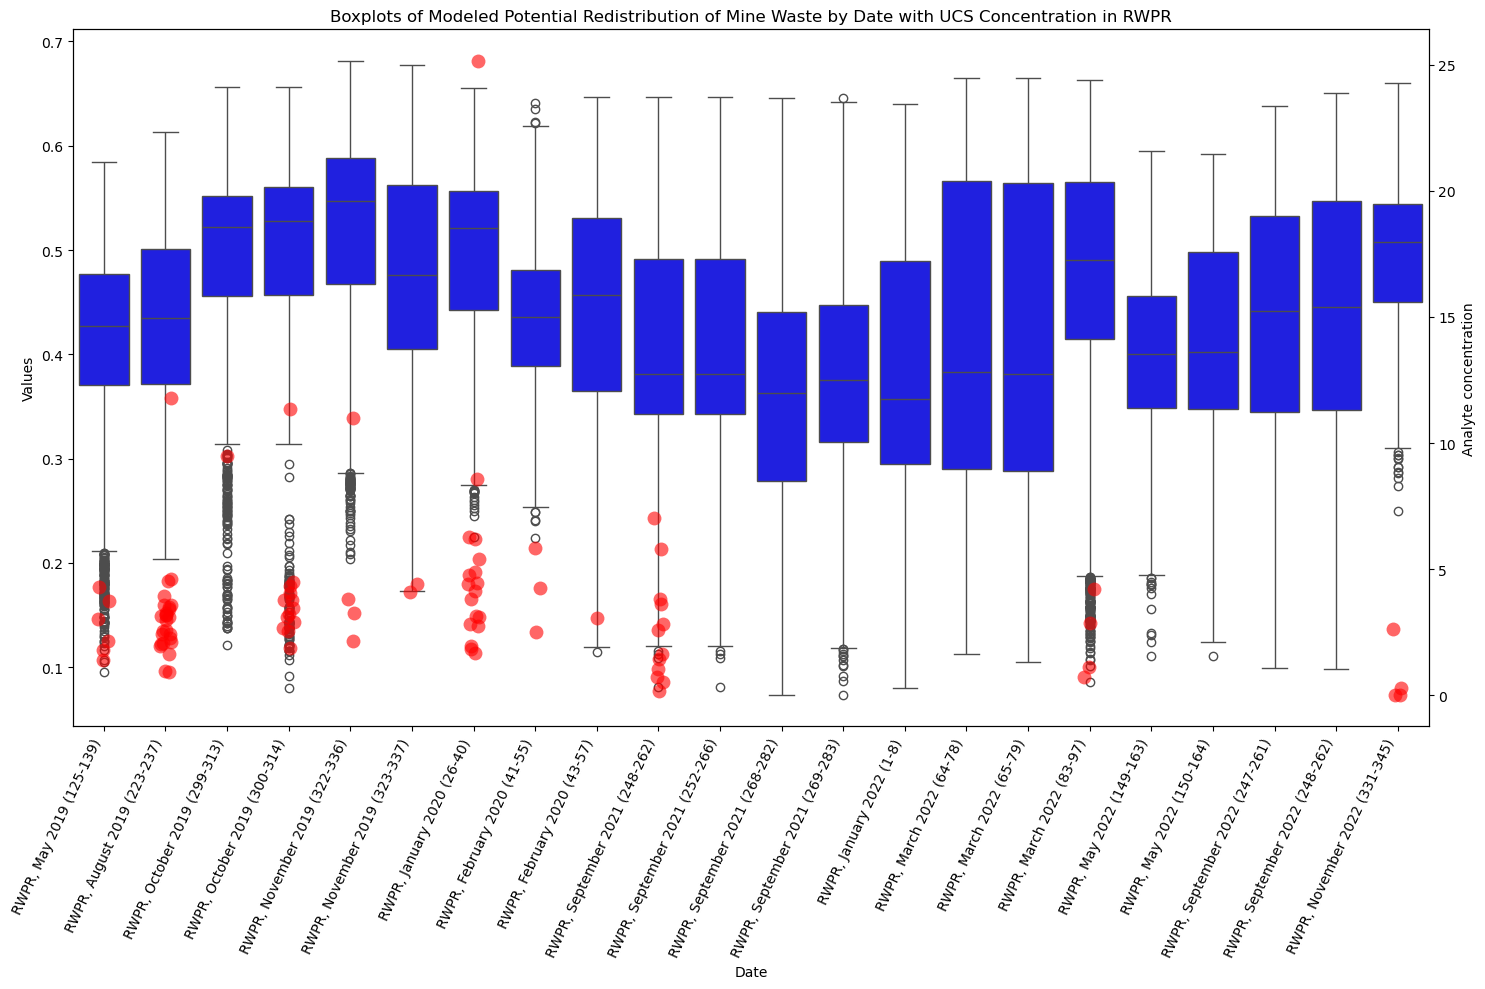

In [32]:
#Plot UCS
# Create a color palette
unique_labels = melted_RWPR_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=UCS_df_melted, x='IntuitiveLabel', y='UCS_val', size=10, alpha=0.6,color='red', ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with UCS Concentration in RWPR')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\721567708.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)


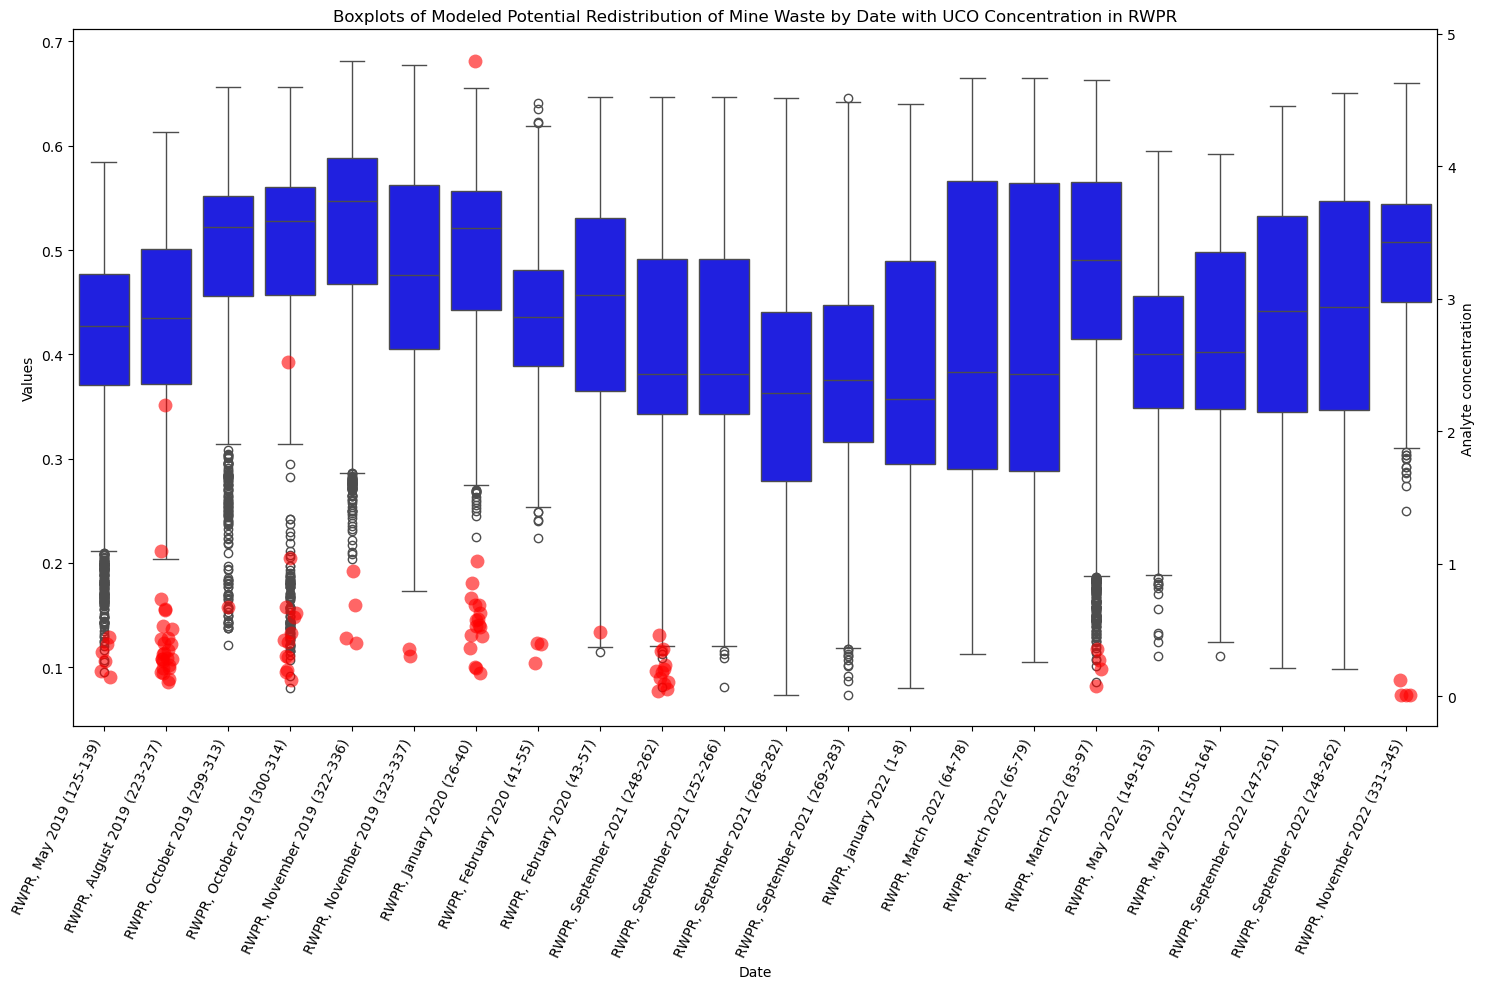

In [33]:
#Plot UCO
# Create a color palette
unique_labels = melted_RWPR_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=UCO_df_melted, x='IntuitiveLabel', y='UCO_val', size=10, alpha=0.6,color='red', ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with UCO Concentration in RWPR')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_8592\2322469149.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)


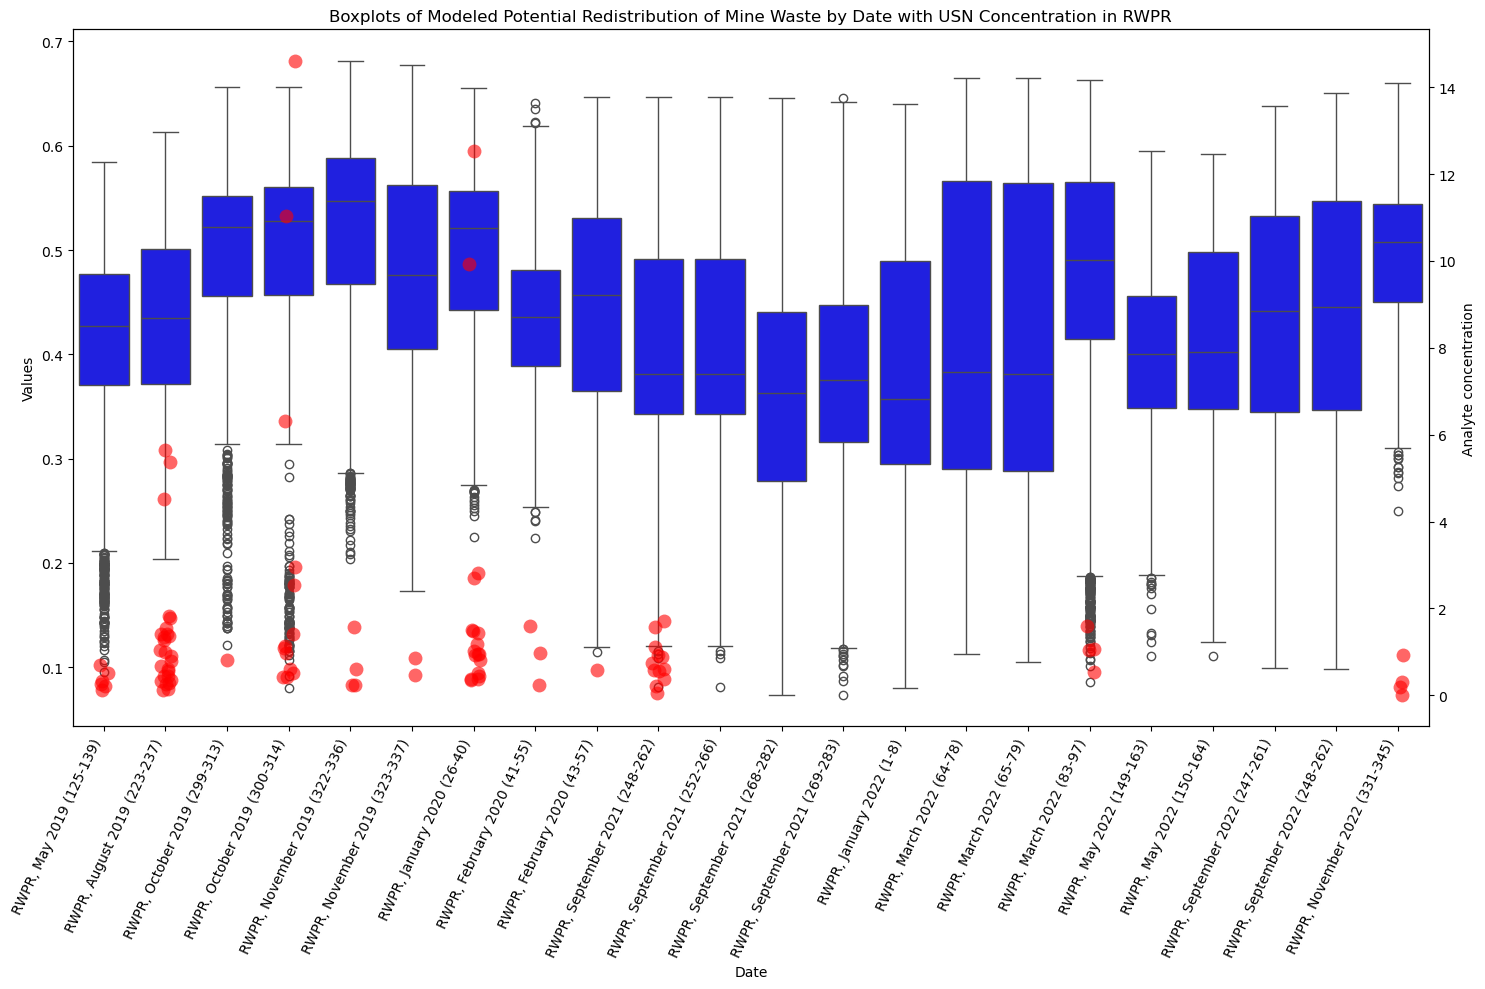

In [34]:
#Plot USN
# Create a color palette
unique_labels = melted_RWPR_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
ax1 = sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_RWPR_df, palette=palette)
ax2 = ax1.twinx()
sns.stripplot(data=USN_df_melted, x='IntuitiveLabel', y='USN_val', size=10, alpha=0.6,color='red', ax=ax2)

#plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.setp(ax1.get_xticklabels(), rotation=65, ha='right')
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date with USN Concentration in RWPR')
#plt.xlabel('List')
ax1.set_xlabel('Date')
plt.ylabel('Values')
plt.ylabel('Analyte concentration')
plt.tight_layout()
plt.show()

In [5]:
# OPTIONAL: Drop rows by 'visit' to only include pre- or post-zinc supplementation
data = data[~data['visit'].isin([3,4])] # Dropping 3 and 4 means that we only have pre-supplementation visits (1 & 2)
print(data['visit'].unique()) # Check which visits are present

[2 1]


# Bootstrap Sampling
## Random Environmental Variables, Stratified by Community

In [6]:
# Stratify by community
# List of analytes
analytes = ['UTAS' # Urine samples start with U, serum with S
          , 'UV'
          , 'USE'
          , 'UFE'
          , 'UBE'
          , 'UCO'
          , 'USR'
          , 'UMO'
          , 'USN'
          , 'USB'
          , 'UCS'
          , 'UBA'
          , 'UW'
          , 'UPT'
          , 'UPB'
          , 'UUR'
          , 'UCD'
          , 'UMN'
          #, 'SCU'
          #, 'SZN'
          #, 'STAS'
          #, 'SSE'
           ]

# List to store spearman rank coefficients for each bootstrap iteration
bootstrap_results = []

# Dictionary to track the first print for each analyte
first_print = {analyte: True for analyte in analytes}

# Bootstrap n times
for _ in range(10000): # Change this
    # Create a new column 'rand_vals' in the data df
    data['rand_vals'] = np.nan

    # Write random values from extracted_values to rand_values based on dictionary key
    for index, row in data.iterrows():
        community = row['community']
        raster = row['raster']
        key = f"{community}_{raster}"
        
        if key in extracted_values:
            # Extract one random value 
            random_value = random.choice(extracted_values[key])
            data.at[index, 'rand_vals'] = random_value

    # Dictionary to store spearman rank coefficients for iteration
    spearman_results = {analyte: {comm: np.nan for comm in data['community'].unique()} for analyte in analytes}

    # Spearman rank coefficient between 'rand_vals' and each analyte for each community
    for community in data['community'].unique():
        community_data = data[data['community'] == community]
        
        for analyte in analytes:
            analyte_values = community_data[analyte]
            
            # Drop NA 
            clean_data = community_data.dropna(subset=['rand_vals', analyte])
            
            # Count NA
            na_count = len(community_data) - len(clean_data)
            if first_print[analyte]:
                print(f'# NAs in {analyte} ({community}): {na_count}')
                first_print[analyte] = False
            
            if pd.api.types.is_numeric_dtype(analyte_values) and len(analyte_values.unique()) > 1:
                correlation, _ = spearmanr(clean_data['rand_vals'], clean_data[analyte])
                spearman_results[analyte][community] = correlation

    # Append each iteration to bootstrap_results 
    bootstrap_results.append(spearman_results)

# Convert bootstrap_results to a DataFrame
flattened_results = []
for result in bootstrap_results:
    for analyte, comm_data in result.items():
        for comm, value in comm_data.items():
            flattened_results.append({'Analyte': analyte, 'Community': comm, 'Spearman_Correlation': value})

bootstrap_df = pd.DataFrame(flattened_results)

# Create the mean Spearman correlation table
mean_spearman = bootstrap_df.groupby(['Community', 'Analyte']).mean().reset_index()

# Pivot the table to get communities as columns and analytes as rows
mean_spearman_pivot = mean_spearman.pivot(index='Analyte', columns='Community', values='Spearman_Correlation')

# Display the average Spearman correlation table
print(mean_spearman_pivot)

# Save the average Spearman correlation table to a CSV file
mean_output_path = file_path + '/mean_spearman_by_comm.csv'
mean_spearman_pivot.to_csv(mean_output_path)

# Confirm that the files have been saved
mean_output_path

# NAs in UTAS (BGT): 1
# NAs in UV (BGT): 1
# NAs in USE (BGT): 1
# NAs in UFE (BGT): 1
# NAs in UBE (BGT): 0
# NAs in UCO (BGT): 1
# NAs in USR (BGT): 1
# NAs in UMO (BGT): 1
# NAs in USN (BGT): 1
# NAs in USB (BGT): 1
# NAs in UCS (BGT): 1
# NAs in UBA (BGT): 1
# NAs in UW (BGT): 1
# NAs in UPT (BGT): 0
# NAs in UPB (BGT): 1
# NAs in UUR (BGT): 1
# NAs in UCD (BGT): 1
# NAs in UMN (BGT): 1


KeyboardInterrupt: 

In [ ]:
# Save as csv
output_path = file_path + '/TZ/bootstrap_spearman_df_v12.csv'
bootstrap_df.to_csv(output_path, index=False)
output_path

print(bootstrap_df.head())

## Pseudo p-value
### Multiple Permutations of Participant Samples

How to characterize significance of bootstrapped correlations:

10k permutations randomly sampling participants - using new permuted distribution, count proportion of the absolute value of the permutations that are larger than the absolute value of the null distribution (the mean of the bootstrapped samples I already have), multiplied by two (because two-sided distribution). If there is no relationship, we expect the proportion to be 0.5: the smaller the proportion, the higher the significance.

2*prob(|rboot|>|rmean|)


In [ ]:
n_permutations = 10  # Change this

# List of analytes
analytes = ['UTAS', 'UV', 'USE', 'UFE', 'UBE', 'UCO', 'USR', 'UMO', 'USN', 'USB', 'UCS', 'UBA', 'UW', 'UPT', 'UPB', 'UUR', 'UCD', 'UMN', 'SCU', 'SZN', 'STAS', 'SSE']

# Load the previously saved bootstrapped mean Spearman correlations
mean_spearman = pd.read_csv(file_path + '/mean_spearman_by_comm.csv', index_col='Analyte')

# Dictionary to store the permutation test results
permutation_results = {analyte: {comm: [] for comm in data['community'].unique()} for analyte in analytes}

# Perform permutations
for _ in range(n_permutations):
    for analyte in analytes:
        for community in data['community'].unique():
            community_data = data[data['community'] == community]
            analyte_values = community_data[analyte].copy()

            # Shuffle the analyte values to create a permuted distribution
            permuted_analyte_values = analyte_values.sample(frac=1, replace=False).reset_index(drop=True)
            
            # Calculate the Spearman correlation with the permuted data
            correlation, _ = spearmanr(community_data['rand_vals'], permuted_analyte_values)
            
            # Store the permuted correlation
            permutation_results[analyte][community].append(correlation)

# Calculate the proportion for each analyte and community
significance_results = []

for analyte in analytes:
    for community in data['community'].unique():
        # Get the mean Spearman correlation from the bootstrap results
        r_mean = mean_spearman.loc[analyte, community]
        
        # Calculate the proportion of permuted correlations greater than the mean correlation
        count = sum(abs(correlation) > abs(r_mean) for correlation in permutation_results[analyte][community])
        
        # Calculate the p-value
        p_value = min(1, 2 * (count / n_permutations))
        
        # Store the results
        significance_results.append({
            'Analyte': analyte,
            'Community': community,
            'Mean_Spearman': r_mean,
            'P_Value': p_value
        })

# Convert the results to a DataFrame
significance_df = pd.DataFrame(significance_results)

# Sigdigs of p-vals
significance_df['P_Value'] = significance_df['P_Value'].apply(lambda x: '{:.15f}'.format(x))

# Pivot the table to get the desired format with one row per analyte and columns for each community's mean Spearman and p-value
significance_pivot = significance_df.pivot(index='Analyte', columns='Community')

# Flatten the MultiIndex columns
significance_pivot.columns = ['_'.join(col).strip() for col in significance_pivot.columns.values]

# Display the significance table
print(significance_pivot)

# Save the significance table to a CSV file
significance_output_path = file_path + '/significance_spearman_by_comm.csv'
significance_pivot.to_csv(significance_output_path)

# Confirm that the file has been saved
significance_output_path

In [ ]:
# List to store the bootstrapped correlation distributions (instead of just the mean)
bootstrap_distributions = {analyte: {comm: [] for comm in data['community'].unique()} for analyte in analytes}

# Perform bootstrapping n times
for _ in range(10000):  # Change this if needed
    data['rand_vals'] = np.nan  # Create a new column 'rand_vals' in the data

    # Write random values from extracted_values to rand_vals based on dictionary key
    for index, row in data.iterrows():
        community = row['community']
        raster = row['raster']
        key = f"{community}_{raster}"

        if key in extracted_values:
            random_value = random.choice(extracted_values[key])
            data.at[index, 'rand_vals'] = random_value

    # Calculate the spearman correlation between 'rand_vals' and each analyte for each community
    for community in data['community'].unique():
        community_data = data[data['community'] == community]
        for analyte in analytes:
            analyte_values = community_data[analyte]

            clean_data = community_data.dropna(subset=['rand_vals', analyte])

            if pd.api.types.is_numeric_dtype(analyte_values) and len(analyte_values.unique()) > 1:
                correlation, _ = spearmanr(clean_data['rand_vals'], clean_data[analyte])
                bootstrap_distributions[analyte][community].append(correlation)  # Append correlation to distribution

# At this point, bootstrap_distributions contains the full distribution of bootstrapped correlations for each analyte-community pair


In [ ]:
# Define the number of permutations
n_permutations = 10000  # Change this as needed

# Dictionary to store the permutation test results
permutation_results = {analyte: {comm: [] for comm in data['community'].unique()} for analyte in analytes}

# Perform permutations
for _ in range(n_permutations):
    for analyte in analytes:
        for community in data['community'].unique():
            community_data = data[data['community'] == community]
            analyte_values = community_data[analyte].copy()

            # Shuffle the analyte values to create a permuted distribution
            permuted_analyte_values = analyte_values.sample(frac=1, replace=False).reset_index(drop=True)

            # Calculate the Spearman correlation with the permuted data
            correlation, _ = spearmanr(community_data['rand_vals'], permuted_analyte_values)

            # Store the permuted correlation
            permutation_results[analyte][community].append(correlation)

# Calculate the proportion for each analyte and community
significance_results = []

for analyte in analytes:
    for community in data['community'].unique():
        # Retrieve the bootstrapped correlation distribution for this analyte-community pair
        bootstrapped_corrs = bootstrap_distributions[analyte][community]

        # Calculate the proportion of permuted correlations greater than the bootstrapped correlations
        count = sum(abs(correlation) > max(abs(c) for c in bootstrapped_corrs) for correlation in permutation_results[analyte][community])

        # Calculate the pseudo p-value
        p_value = min(1, 2 * (count / n_permutations))

        # Store the results
        significance_results.append({
            'Analyte': analyte,
            'Community': community,
            'Correlation': max(bootstrapped_corrs),  # Get the max observed correlation from the bootstraps
            'P_Value':'{:.15f}'.format(p_value)
        })

# Convert the results to a DataFrame
significance_df = pd.DataFrame(significance_results)

# Display and save the significance table
print(significance_df)
#significance_df.to_csv(file_path + '/significance_spearman_by_comm.csv', index=False)
